# 내가 직접 만들지 않고 가져다 쓰는 강아지 고양이 분류기
실제 이미지를 분류할 때는 보통 이미 만들어진 성능 좋은 모델을 가지고 와서 사용할 것이다.

- [ILSVRC 대회 (이미지넷 이미지 인식 대회) 역대 우승 알고리즘들](https://bskyvision.com/425) 
- [CNN-Imagenet에 쓰인 주요 모델](https://www.sallys.space/blog/2018/01/26/cnn-imagenet/)
- [CNN 성능은 어떻게 평가하게 되나요?](https://89douner.tistory.com/59)

**Transfer Learning(전이학습)**

- [Transfer Learning｜학습된 모델을 새로운 프로젝트에 적용하기](https://jeinalog.tistory.com/13)

- 전이학습을 활용하기 위한 전략 3가지
 - 전략 1은 전체 모델을 새로 학습시키는 것이다. 이 경우에는 사전학습 모델의 구조만 사용한다. 모델을 완전히 새로 학습시켜야하므로, 큰 사이즈의 데이터셋과 좋은 컴퓨팅 연산 능력이 있을 때 적합하다.
 - 전략 2는 Convolutional base의 일부분은 고정시킨 상태로, 나머지 계층과 classifier만 새로 학습시키는 것이다. 데이터셋의 크기에 따라 얼마나 많은 계층을 새로 학습시킬지 달라지는데, 데이터의 양이 많을수록 더 많이 새로 학습시키고, 데이터의 양이 적을수록 학습시키는 부분을 적게 한다.
 - 전략 3은 Convolutional base는 고정시키고, classifier만 새로 학습시키는 것이다. 이 경우는 convolutional base는 건들지 않고 그대로 두면서 특징 추출 메커니즘으로 활용하고, classifier만 재학습시키는 방법이다. 컴퓨팅 연산능력이 부족하거나 데이터셋이 작을 때 고려해볼 수 있다.


여기에서 사용할 전이학습모델은 ILSVRC에서 쓰인 모델로, 해당 대회는 수백 만 장의 데이터로 학습된 모델이다. 강아지와 고양이 데이터는 약 2만 장으로, 비교적 매우 작은 데이터셋이다. 따라서 모델을 새로 학습시키기보다는, 가져오는 모델은 이미지에서 특징을 추출하는 메커니즘으로 활용하고, classifier만 새로 학습시키는 전략 3이 적절할 것같다.

## 사전 학습 모델인 VGG16을 가져오고, 모델의 구조 확인하기

2014년의 ILSVRC 물체 위치 찾기(localization) 태스크에서 우승한 VGG 모델을 사용해보자
 - [텐서플로우 튜토리얼 - VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16)
 - [VGG16 모델 구조](https://neurohive.io/en/popular-networks/vgg16/)
 ![img](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
feature_batch.shape, image_batch.shape

(TensorShape([32, 5, 5, 512]), TensorShape([32, 160, 160, 3]))

base_model에 이 배치를 넣으면 shape이 바뀌었다. 이미지의 개수는 32장으로 여전히 같은데, height와 width는 각각 5로 매우 작아졌고, 512로 channel이 늘어났다.

이런 모델구조에서 우리는 전이학습시 Dense레이어만 따로 구성하여 모델의 끝부분만 커스터마이징 해보자

## VGG16 끝단에 classifier 레이어를 붙여서 원하는 구조의 분류 모델 만들기
VGG16이 출력하는 벡터가 (5, 5, 512)로 3차원의 구조를 가졌는데 분류기에 붙이려면 1차원 벡터로 변환하여 주어야한다.

3차원이었던 벡터를 일렬로 쭉 펴는 역할을 하는 계층이 바로 Flatten 레이어이다.

Flattening 방법
- Global Average Pooling : [참고](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/global-average-pooling-2d)
![이미지](https://peltarion.com/static/global_average_pooling_a.png)
 - (Height, Width, Depth)의 shape를 가지는 3차원 이미지를 (1, 1, Depth)로 바꿔준다. 
 - 왼쪽의 3차원 배열에서 맨 앞 장인 [[1, 5, 4, 5], ..., [8, 6, 8, 7]] 에 있는 16개 숫자의 평균을 구하면 '5'라는 숫자가되는 것처럼 평균값을 활용해 벡터의 차원을 줄이는 방법이다.


우리가 사용할 VGG16이 출력한 벡터가 [32, 5, 5, 512]였으니, Global Average Pooling을 취하면 벡터의 shape은 [32, 1, 1, 512]가 된다. 이는 [32, 512]로 볼 수 있다.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 2)


In [ ]:
base_model.trainable = False
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


VGG16 안에는 위에서 봤던 매우 복잡한 레이어들이 들어있는데, base_model로 추상화시켰기 때문에 간결하게 나타난다.

## VGG16을 기반으로 구성된 이미지 분류기를 학습

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

초기 손실과 정확도 값을 확인해보자

In [ ]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 9s 138ms/step - loss: 0.7246 - accuracy: 0.4750
initial loss: 0.72
initial accuracy: 0.47


 이전에 만든 보델보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분하다.


In [ ]:
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 124s 208ms/step - loss: 0.2492 - accuracy: 0.9106 - val_loss: 0.1702 - val_accuracy: 0.9329
Epoch 2/5
582/582 [==============================] - 115s 194ms/step - loss: 0.1589 - accuracy: 0.9362 - val_loss: 0.1547 - val_accuracy: 0.9377
Epoch 3/5
582/582 [==============================] - 115s 194ms/step - loss: 0.1451 - accuracy: 0.9404 - val_loss: 0.1459 - val_accuracy: 0.9411
Epoch 4/5
582/582 [==============================] - 115s 194ms/step - loss: 0.1378 - accuracy: 0.9427 - val_loss: 0.1416 - val_accuracy: 0.9394
Epoch 5/5
582/582 [==============================] - 115s 194ms/step - loss: 0.1331 - accuracy: 0.9449 - val_loss: 0.1382 - val_accuracy: 0.9441


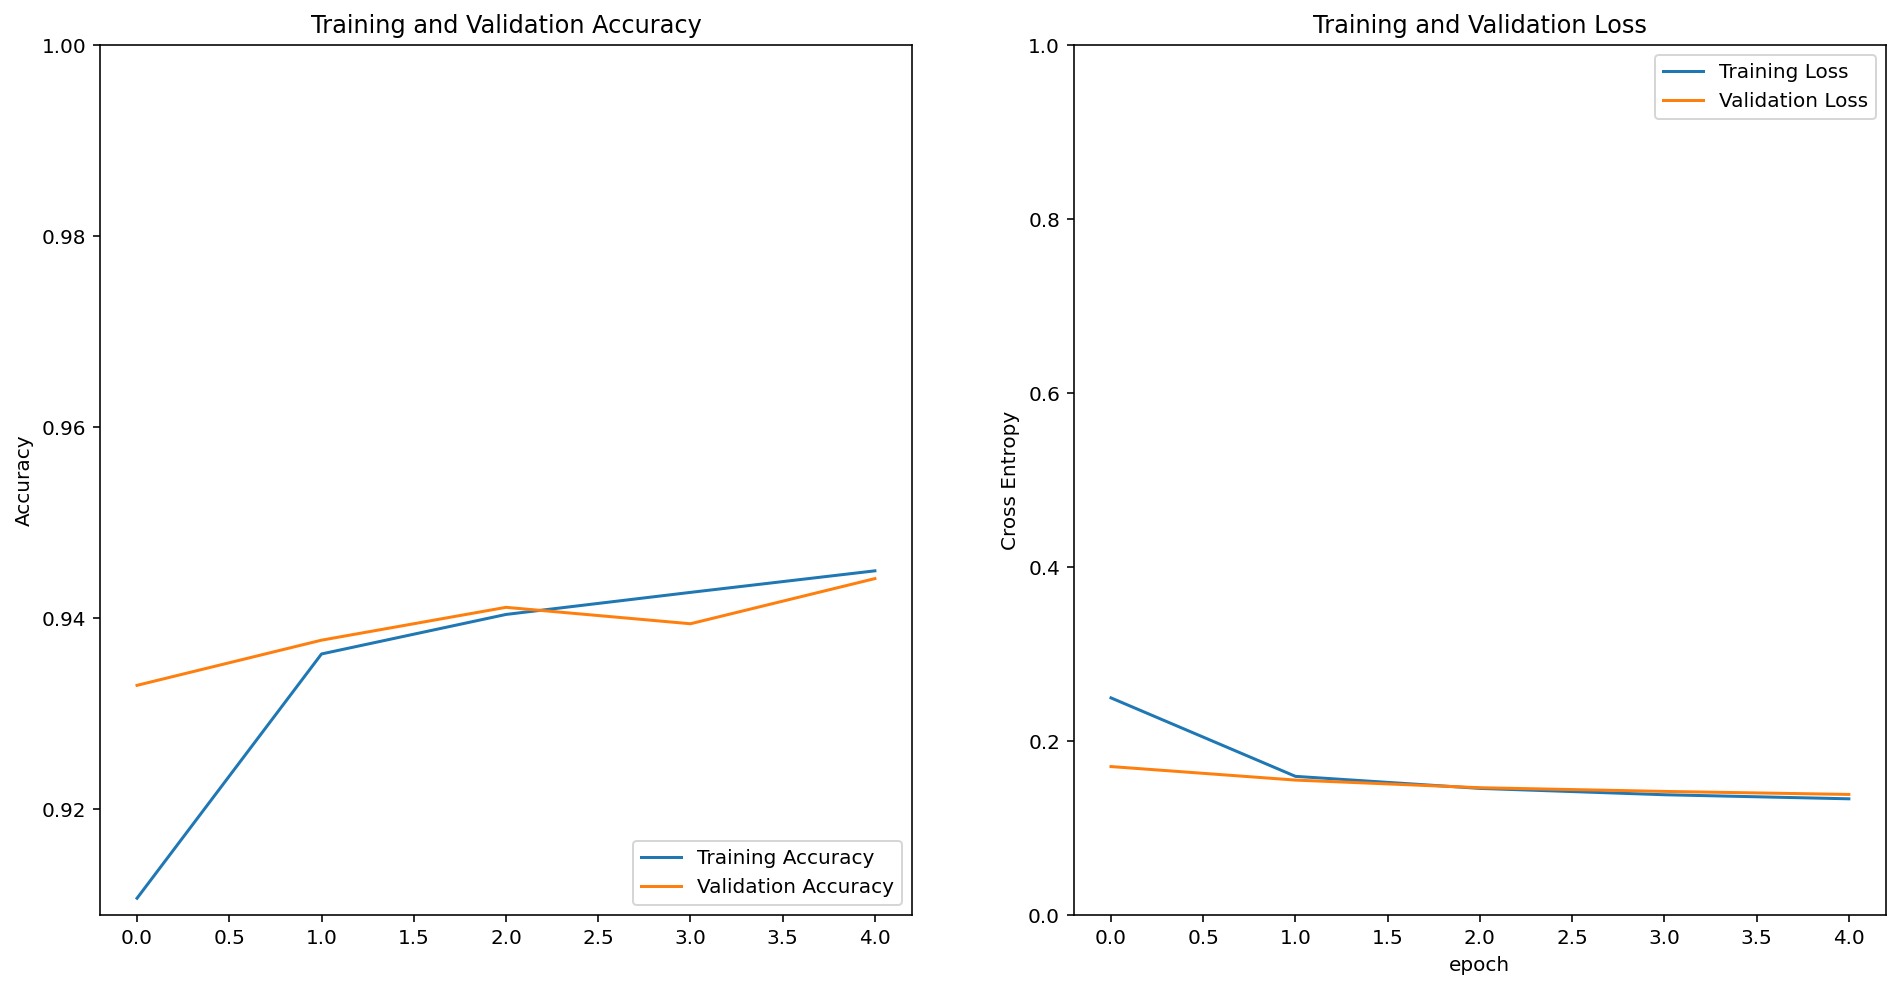

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

학습되는 과정을 보면 시작부터 75%를 넘는 정확도에서 꾸준히 올라갈뿐만 아니라 validation loss도 매우 안정적인 모습니다

테스트 배치하나를 가져와 예측해보자

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9998772e-01, 1.2333104e-05],
       [1.3446160e-01, 8.6553842e-01],
       [3.3115453e-01, 6.6884547e-01],
       [9.9999392e-01, 6.0220727e-06],
       [9.9795735e-01, 2.0425839e-03],
       [9.8611361e-01, 1.3886439e-02],
       [1.8354115e-04, 9.9981648e-01],
       [6.4555967e-01, 3.5444036e-01],
       [9.6048915e-01, 3.9510868e-02],
       [9.6415341e-01, 3.5846632e-02],
       [5.1819905e-05, 9.9994814e-01],
       [9.9996114e-01, 3.8889146e-05],
       [9.8848838e-01, 1.1511594e-02],
       [3.0880628e-06, 9.9999690e-01],
       [9.9851757e-01, 1.4824718e-03],
       [9.8564917e-01, 1.4350776e-02],
       [9.9688703e-01, 3.1129895e-03],
       [3.3218451e-02, 9.6678156e-01],
       [6.4424914e-01, 3.5575092e-01],
       [9.9588782e-01, 4.1122469e-03],
       [9.3653631e-01, 6.3463666e-02],
       [9.8161131e-01, 1.8388627e-02],
       [9.9393409e-01, 6.0658674e-03],
       [9.8030490e-01, 1.9695176e-02],
       [9.9834859e-01, 1.6514190e-03],
       [9.8090750e-01, 1.

predictions 값들을 실제 추론한 라벨(고양이:0, 강아지:1)로 변환해보자

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

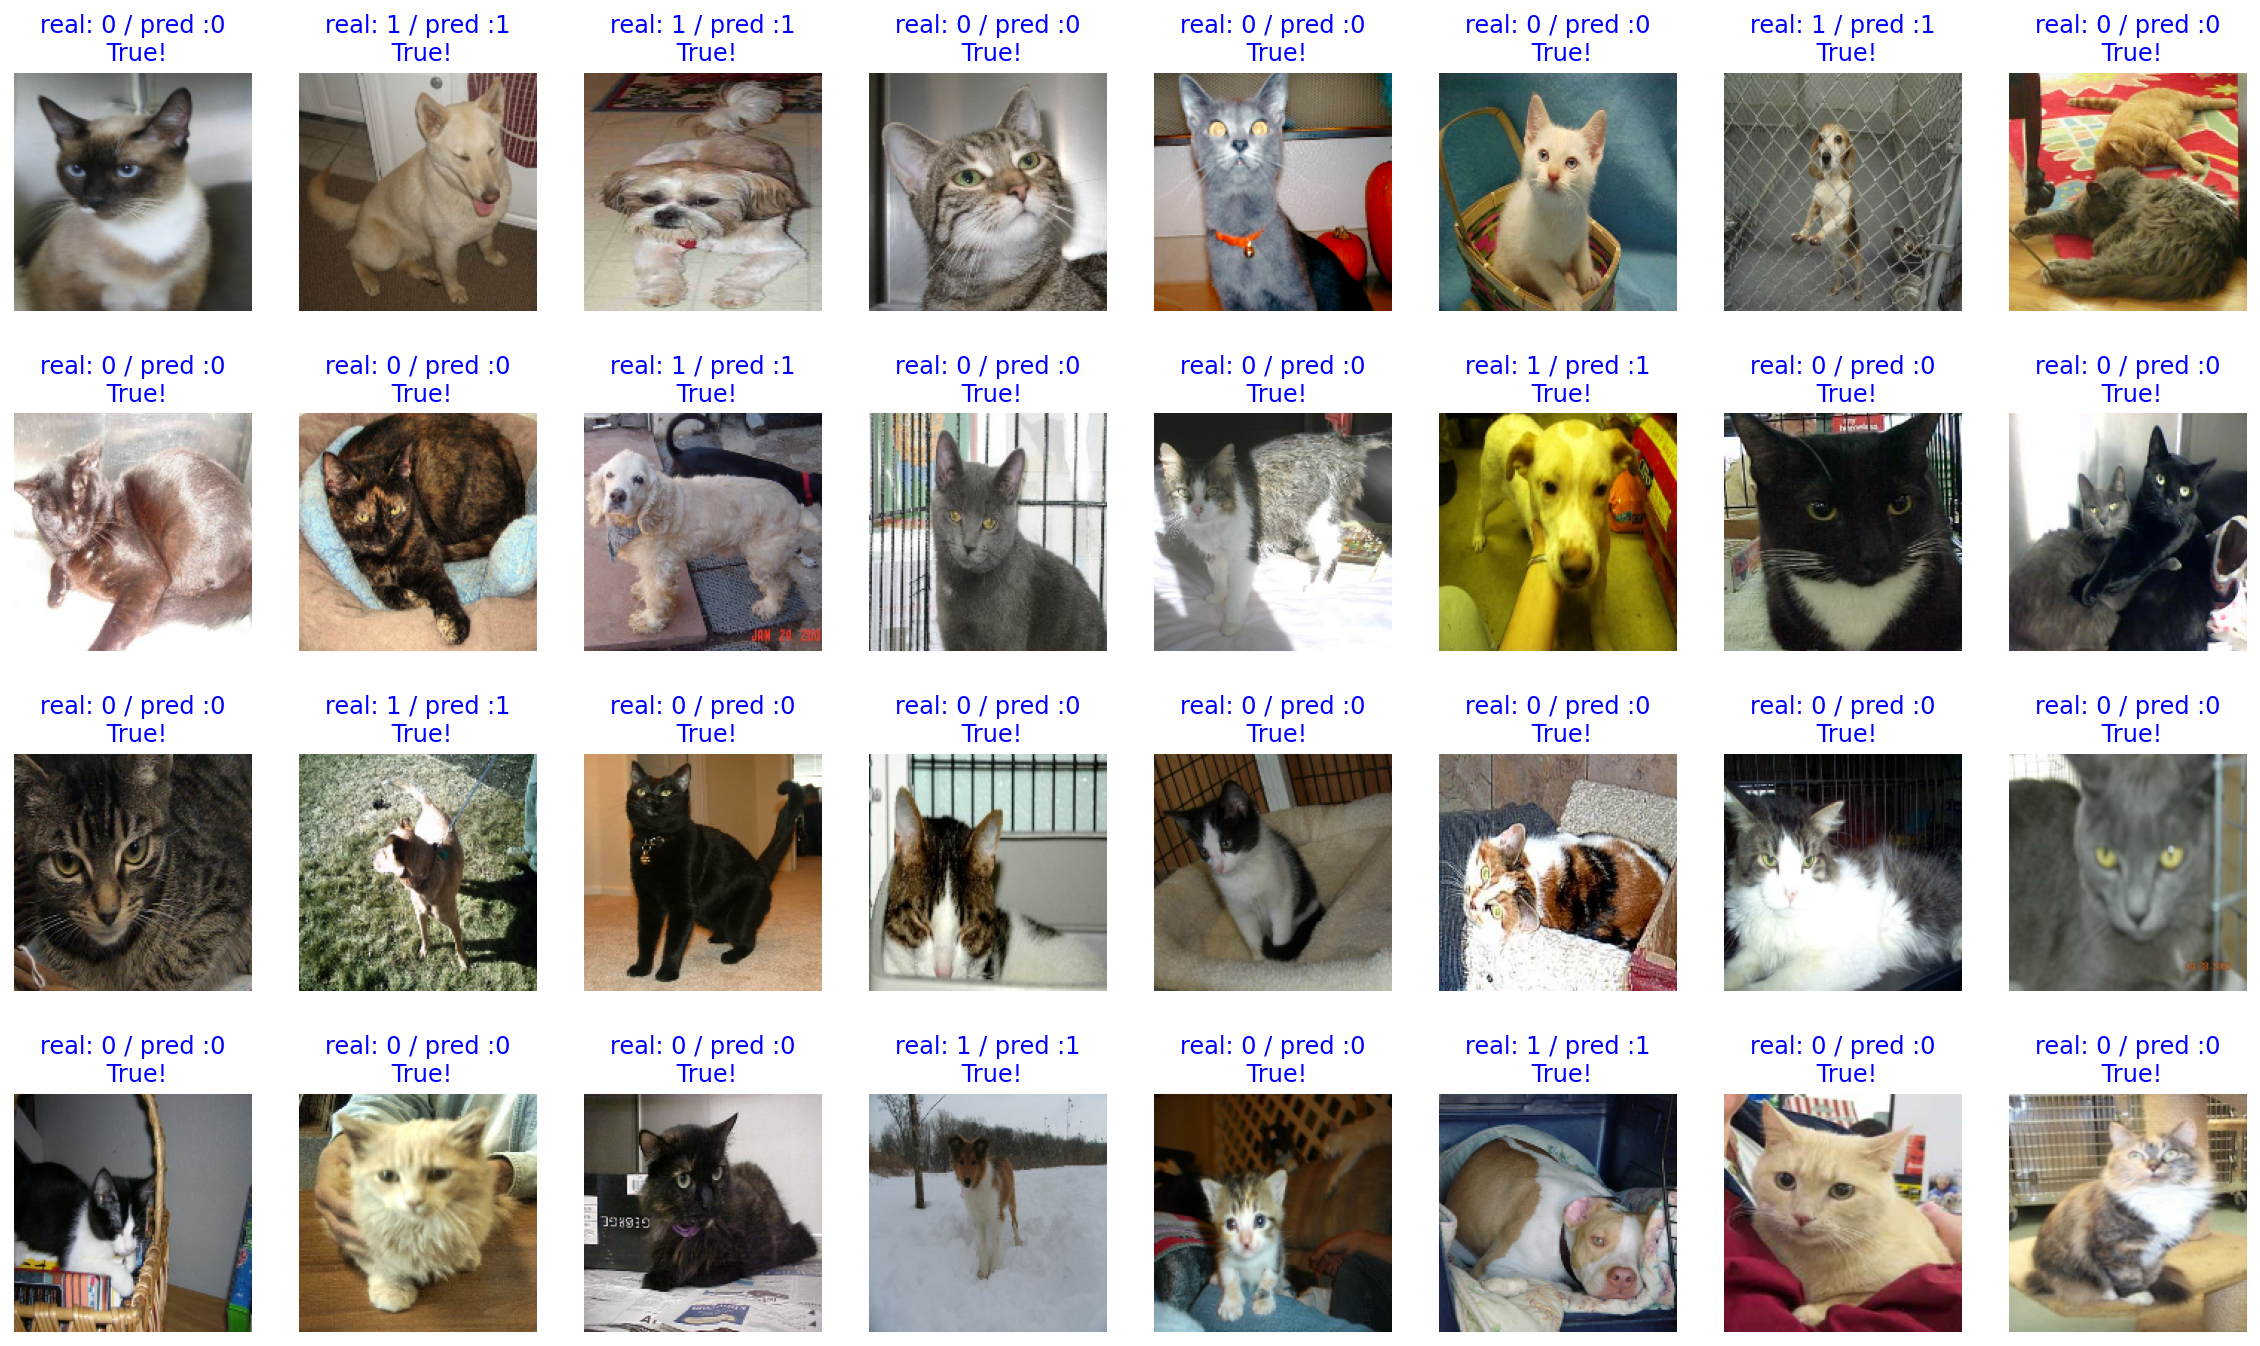

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

32개 샘플에 대한 정확도를 확인해보자

In [ ]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

100.0


확실히 직접 밑바닥부터 모델을 만드는 것보다 잘만들어진 모델을 가져오는 전이학습이 문제를 잘 해결하고있다.